# BT4222 Data Preprocess

## Introduction
We begin by preprocessing movie metadata and user ratings from the TMDB and MovieLens datasets. Rich content features such as genre, cast, director, production company, and language are extracted and embedded using NLP techniques (spaCy). These embeddings form the basis for content similarity.


## Mount Google Drive
This code cell mounts your Google Drive in the Colab environment, enabling access to datasets stored in your drive for subsequent processing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries and Load Raw Datasets
This block performs the initial setup by:

Importing necessary libraries such as pandas and numpy for data manipulation, spacy for NLP embeddings, and MultiLabelBinarizer for multi-label encoding.

Loading all primary datasets used in the project:

- `tmdb_5000_movies.csv`: Contains movie metadata such as title, genres, overview, release date, etc.

- `tmdb_5000_credits.csv`: Contains cast and crew information for each movie.

- `ratings.csv`: Contains user ratings for movies.

- `links.csv`: Connects MovieLens IDs to TMDB IDs for aligning external metadata.

These datasets form the backbone for building a hybrid recommendation system that leverages both content features and user-item interactions.

In [ ]:
import pandas as pd
import numpy as np
import spacy
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns


tmdb_5000_credits = pd.read_csv("/content/drive/MyDrive/BT4222_Project/tmdb_5000_credits.csv")
tmdb_5000_movies = pd.read_csv("/content/drive/MyDrive/BT4222_Project/tmdb_5000_movies.csv")

df_links = pd.read_csv("/content/drive/MyDrive/BT4222_Project/links.csv")
df_ratings = pd.read_csv("/content/drive/MyDrive/BT4222_Project/ratings.csv")


## Data Cleaning and Feature Engineering on TMDB Metadata
This block performs extensive preprocessing and feature enrichment on the TMDB datasets to ensure clean, usable input for the recommendation model.

## Data Cleaning Steps:
- Column Renaming: The id column in the movie dataset is renamed to `movie_id` for consistency during merging.

- Missing Values: Removes any rows that contain missing values.

- Vote Count Threshold: Filters out movies with fewer than 10 votes to eliminate obscure, unreliable entries.

- Dataset Merge: Merges the movie metadata and credit datasets based on `movie_id` to bring all relevant information together.

- Date Parsing: Converts the `release_date` string to datetime format for date-based feature extraction.

## Feature Engineering Steps:
- Main Cast: Extracts the top 5 cast members for each movie and stores them in a list format.

- Director Extraction: Isolates the name(s) of the director(s) from the crew data for each movie.

- Weighted Vote Score: Computes a custom weighted rating score to better reflect a movie's quality by accounting for both average rating and number of votes. This weighted score balances rating and vote count, reducing bias from low-vote movies.

- Genre Encoding: Uses one-hot encoding to transform the multi-genre field into a binary matrix using MultiLabelBinarizer.

- Movie Age: Calculates how many years have passed since each movie’s release (based on the year 2025).

- Production Company: Extracts the name of the primary production company from a JSON-like field.

/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:474: RuntimeWarning: invalid value encountered in subtract
  edges = res[orient].to_numpy() - widths / 2


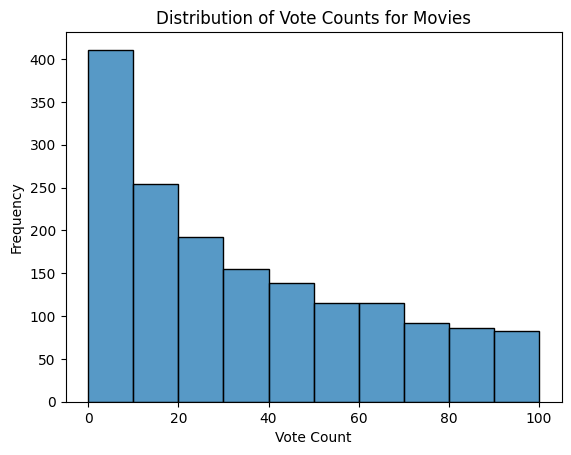

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional: For a more stylish histogram
import numpy as np

# Create custom bins
bins = np.arange(0, 110, 10)  # Bins from 0 to 100 with a step of 10
bins = np.append(bins, np.inf)  # Add an extra bin for values above 100

# Optional: Using Seaborn for a more stylish histogram
sns.histplot(tmdb_5000_movies['vote_count'], bins=bins, kde=False) # kde=False removes the density curve

plt.title('Distribution of Vote Counts for Movies')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#### Data Cleaning ####

# Rename the 'id' column to 'movie_id' in tmdb_5000_movies
tmdb_5000_movies.rename(columns={'id': 'movie_id'}, inplace=True)

# Remove missing NA values
tmdb_5000_movies.dropna(inplace=True)

# Remove movies with less than 10 vote counts
tmdb_5000_movies = tmdb_5000_movies[tmdb_5000_movies['vote_count'] >= 10]

# Merge the two DataFrames on 'movie_id'
df_full_tmdb = pd.merge(tmdb_5000_movies, tmdb_5000_credits, on='movie_id', how='inner')

# Convert 'release_date' to datetime
df_full_tmdb['release_date'] = pd.to_datetime(df_full_tmdb['release_date'])


#### Feature Engineering ####

# Cast name (first 5)
df_full_tmdb['main_cast'] = df_full_tmdb['cast'].apply(lambda x: [i['name'] for i in literal_eval(x)][0:5])

# Extract director
df_full_tmdb['director'] = df_full_tmdb['crew'].apply(lambda x: [i['name'] for i in literal_eval(x) if i['job'] == 'Director'])

# Weighted Vote Score
mean_vote_count = df_full_tmdb['vote_count'].mean()
df_full_tmdb['weighted_vote_score'] = (df_full_tmdb['vote_average'] * df_full_tmdb['vote_count']) / (df_full_tmdb['vote_count'] + mean_vote_count)

# Genre One-Hot Encoding
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_full_tmdb['genres'])
df_full_tmdb['genre'] = genre_encoded.tolist()

# Movie Age
df_full_tmdb['release_year'] = pd.to_datetime(df_full_tmdb['release_date']).dt.year
df_full_tmdb['movie_age'] = 2025 - df_full_tmdb['release_year']

# Production Company
df_full_tmdb['production_company'] = df_full_tmdb['production_companies'].apply(
    lambda x: [i['name'] for i in literal_eval(x)][0:1] if pd.notna(x) and isinstance(x, str) else []
)

# Apply Embeddings
!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')
def get_vector_safe(text):
    try:
        return nlp(text).vector
    except:
        return np.zeros(300)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 53.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Generate Embeddings for Textual Features
This block creates vector embeddings for several important textual attributes using the spaCy model initialized earlier. These embeddings are essential for enabling semantic comparisons between movies based on director, cast, language, etc.

- Director Embedding: Converts the director’s name into a 300-dimensional vector.

- Main Cast Embeddings: Transforms each of the top 5 cast members’ names into vectors and stores them as a list of embeddings.

- Production Company Embedding: Encodes the main production company into a semantic vector.

- Original Language Embedding: Encodes the language in which the movie was originally released.

Finally, it selects a curated subset of columns containing the engineered and embedded features, forming the final version of the TMDB content feature dataset.



In [ ]:
# Embed the 'director' column into semantic vectors using spaCy
df_full_tmdb['director_embedding'] = df_full_tmdb['director'].apply(lambda x: get_vector_safe(str(x)))

# Embed each member of the 'main_cast' list into vectors; skip if not a list
df_full_tmdb['main_cast_embeddings'] = df_full_tmdb['main_cast'].apply(
    lambda cast_list: [get_vector_safe(name) for name in cast_list] if isinstance(cast_list, list) else []
)

# Embed the 'production_company' into vectors for downstream modeling
df_full_tmdb['production_company_embedding'] = df_full_tmdb['production_company'].apply(lambda x: get_vector_safe(str(x)))

# Embed the 'original_language' into vectors to capture linguistic context
df_full_tmdb['original_language_embedding'] = df_full_tmdb['original_language'].apply(lambda x: get_vector_safe(str(x)))

# Select specific columns
selected_columns = [
    'movie_id',
    'production_company',
    'movie_age',
    'genre',
    'weighted_vote_score',
    'director',
    'main_cast',
    'original_title',
    'original_language',
    'director_embedding',
    'main_cast_embeddings',
    'production_company_embedding',
    'original_language_embedding'
]

# Create final DataFrame
df_tmdb_final = df_full_tmdb[selected_columns]

In [ ]:
df_tmdb_final.head()



,movie_id,production_company,movie_age,genre,weighted_vote_score,director,main_cast,original_title,original_language,director_embedding,main_cast_embeddings,production_company_embedding,original_language_embedding
0,19995,[Ingenious Film Partners],16,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...",6.452778,[James Cameron],"[Sam Worthington, Zoe Saldana, Sigourney Weave...",Avatar,en,"[-0.6517134, 0.27394998, 0.16546066, -0.076838...","[[-0.83080494, 0.31037998, 0.0033250004, -0.30...","[-0.63437855, 0.06692429, -0.062136855, -0.070...","[-0.71968, -0.4128, -0.29437, -0.45189, 0.2814..."
1,285,[Walt Disney Pictures],18,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...",5.292834,[Gore Verbinski],"[Johnny Depp, Orlando Bloom, Keira Knightley, ...",Pirates of the Caribbean: At World's End,en,"[-0.65839505, 0.08215117, 0.033557337, -0.0356...","[[-0.61544, 0.4122, -0.089683, -0.36034, 0.364...","[-0.64176714, 0.15160428, -0.08260625, -0.1916...","[-0.71968, -0.4128, -0.29437, -0.45189, 0.2814..."
2,206647,[Columbia Pictures],10,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",4.824033,[Sam Mendes],"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Spectre,en,"[-0.64901, 0.29103833, 0.07730234, 0.01580367,...","[[-0.71098, 0.32171, 0.57144, -0.17681, 0.6728...","[-0.62056166, 0.15890665, -0.08253267, -0.1400...","[-0.71968, -0.4128, -0.29437, -0.45189, 0.2814..."
3,49026,[Legendary Pictures],13,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, ...",6.608366,[Christopher Nolan],"[Christian Bale, Michael Caine, Gary Oldman, A...",The Dark Knight Rises,en,"[-0.64368004, 0.34179333, 0.014537334, -0.1435...","[[-0.69798005, -0.16083175, -0.10385301, -0.44...","[-0.64584666, 0.16958833, -0.054879326, -0.040...","[-0.71968, -0.4128, -0.29437, -0.45189, 0.2814..."
4,49529,[Walt Disney Pictures],13,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",3.711986,[Andrew Stanton],"[Taylor Kitsch, Lynn Collins, Samantha Morton,...",John Carter,en,"[-0.643045, 0.268055, 0.069249384, -0.15448967...","[[-0.794855, 0.1932175, 0.17926961, 0.00823799...","[-0.64176714, 0.15160428, -0.08260625, -0.1916...","[-0.71968, -0.4128, -0.29437, -0.45189, 0.2814..."


## Clean and Filter Ratings Dataset
This section ensures that the ratings dataset used for collaborative filtering is of high quality:

- User Filtering: Removes users who have rated fewer than 5 movies. These users provide too little information to make reliable collaborative recommendations.

- Variance Filtering: Excludes users who gave the exact same rating to every movie (standard deviation = 0), as they do not express meaningful preferences.

The result is a more informative and reliable ratings matrix for training collaborative models.

In [ ]:
# Remove users with less than 5 rated movies
df_ratings = df_ratings.groupby('userId').filter(lambda x: len(x) >= 5)

# Remove users with standard deviation of 0
df_ratings = df_ratings.groupby('userId').filter(lambda x: x['rating'].std() > 0)

# print columns
print(df_ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


## Merge Ratings with Movie Content Features
This step combines collaborative filtering signals (user ratings) with rich movie content features by joining three datasets:

- `df_links`: Maps MovieLens movie IDs to TMDB IDs.

- `df_ratings`: User-movie interaction data.

- `df_tmdb_final`: Preprocessed TMDB metadata and embeddings.

This unified `df_merged` DataFrame will be used to simulate recommendations for real users based on both their interaction history and content similarity.

In [ ]:
# Merge df_links and df_ratings on 'movieId'
df_links_with_ratings = pd.merge(df_links, df_ratings, on='movieId', how='inner')

# Filter out rows where 'tmdbId' is missing to ensure clean merging with TMDB metadata
df_links_with_ratings = df_links_with_ratings[df_links_with_ratings['tmdbId'].notna()]

# Convert 'tmdbId' to integer type for consistency before merging
df_links_with_ratings['tmdbId'] = df_links_with_ratings['tmdbId'].astype(int)

# Merge df_links_with_ratings and df_tmdb_final
df_merged = pd.merge(df_links_with_ratings, df_tmdb_final, left_on='tmdbId', right_on='movie_id', how='inner')





<ipython-input-9-1dd740a7d4bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links_with_ratings['tmdbId'] = df_links_with_ratings['tmdbId'].astype(int)
